In [1]:
!pip install torch==2.2.1

In [2]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html


In [3]:
!pip install torch_geometric

In [4]:
a!7z x facebook.tar.gz
!7z x facebook_combined.txt.gz
!7z x facebook.tar


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 732104 bytes (715 KiB)

Extracting archive: facebook.tar.gz
--
Path = facebook.tar.gz
Type = gzip
Headers Size = 10


Would you like to replace the existing file:
  Path:     ./facebook.tar
  Size:     4853760 bytes (4740 KiB)
  Modified: 2012-12-03 03:16:00
with the file from archive:
  Path:     facebook.tar
  Size:     4853760 bytes (4740 KiB)
  Modified: 2012-12-03 03:16:00
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? a

  0% - facebook.tar                   Everything is Ok

Size:       4853760
Compressed: 732104

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,

In [5]:
import torch

In [6]:
import os

In [7]:
from sklearn.cluster import SpectralClustering

In [8]:
import networkx as nx

In [9]:
graph = nx.read_edgelist('facebook_combined.txt')

In [10]:
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def plot_graph(g):
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g, pos, node_size=50)
    nx.draw_networkx_edges(g, pos)
    plt.show()

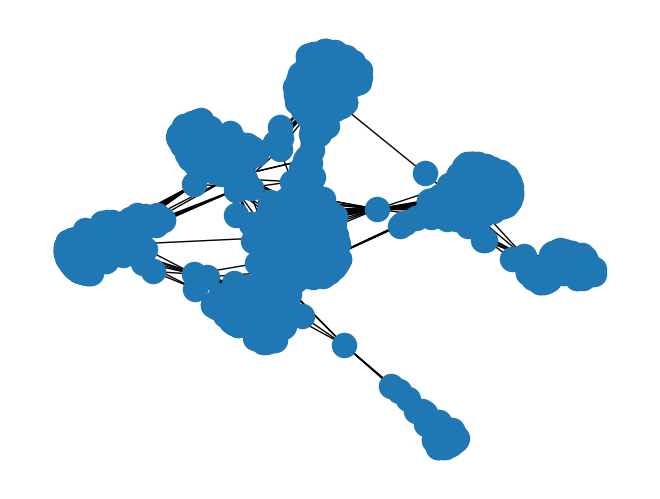

In [12]:
nx.draw_spring(graph)

# Задача 1

In [13]:
clustering = SpectralClustering(affinity='precomputed', n_clusters=10)

In [14]:
adj = nx.adjacency_matrix(graph).toarray()

In [15]:
adj

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
clustering.fit(adj)

SpectralClustering(affinity='precomputed', n_clusters=10)

In [17]:
spectral_labels = clustering.labels_

In [18]:
set(spectral_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(n_components=2)

In [21]:
tsne_emb = tsne.fit_transform(adj)

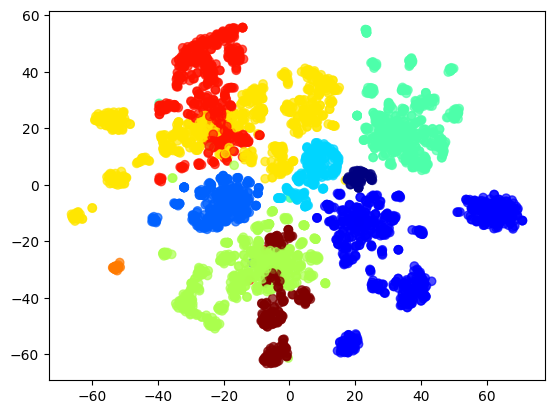

In [22]:
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1],
            c=spectral_labels, cmap='jet', alpha=0.7)

In [23]:
true_classes = list(spectral_labels)

In [24]:
len(true_classes)

4039

In [25]:
ego_nodes = [0, 107, 1684, 1912, 3437, 348, 3980, 414, 686, 698]

In [26]:
id = 0
for n in ego_nodes:
  ego_graph = nx.read_edgelist(f'facebook/{n}.edges')
  for node in ego_graph.nodes:
    true_classes[int(node)] = id
  id += 1

In [27]:
set(true_classes)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [28]:
from sklearn.metrics import adjusted_mutual_info_score, normalized_mutual_info_score

In [29]:
adjusted_mutual_info_score(true_classes, spectral_labels)

0.5462149062948504

In [30]:
normalized_mutual_info_score(true_classes, spectral_labels)

0.548538600307393

# Задача 2

In [31]:
!pip install node2vec

In [32]:
from node2vec import Node2Vec

In [33]:
n2v = Node2Vec(graph=graph, dimensions=10)

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:49<00:00,  4.94s/it]


In [34]:
n2v_model = n2v.fit()

In [35]:
embeddings = {node: n2v_model.wv[node] for node in graph.nodes()}

In [36]:
from sklearn.cluster import KMeans

In [37]:
vectors = list(embeddings.values())

In [38]:
kmeans = KMeans(n_clusters=10)

In [39]:
clusters = kmeans.fit_predict(vectors)

In [40]:
adjusted_mutual_info_score(true_classes, clusters)

0.5239370169581347

In [41]:
normalized_mutual_info_score(true_classes, clusters)

0.5262586115645447

In [42]:
from sklearn.manifold import TSNE

In [43]:
tsne = TSNE(n_components=2)

In [44]:
import numpy as np

In [45]:
tsne_emb = tsne.fit_transform(np.array(vectors))

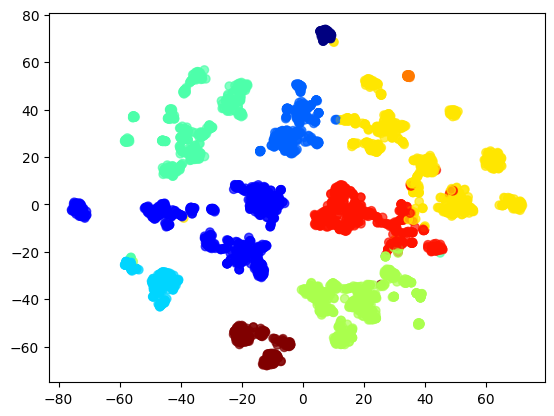

In [46]:
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1],
            c=spectral_labels, cmap='jet', alpha=0.7)

# Задача 3

In [47]:
from torch_geometric.nn import SAGEConv
from torch.nn.functional import dropout
import torch
from torch_geometric.data import Data
import os


In [92]:

class GCN(torch.nn.Module):
    def __init__(self, dimensions=64):
        super().__init__()

        self.conv1 = SAGEConv((-1,-1), 64)
        self.conv2 = SAGEConv((-1,-1), 128)

        self.linear1 = torch.nn.Linear(128, dimensions)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).tanh()
        x = dropout(x, p=0.3)

        x = self.conv2(x, edge_index).tanh()
        x = dropout(x, p=0.3)

        x = self.linear1(x)
        return x


In [49]:

def train(model, dataset, optimizer, criterion, epochs=5):
    if len(dataset.train_mask.shape) > 1:
        train_mask = dataset.train_mask[:, 0]
    else:
        train_mask = dataset.train_mask

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(dataset.x, dataset.edge_index)
        loss = criterion(out[train_mask], dataset.y[train_mask])
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


In [50]:
labels = true_classes
node_features = torch.tensor([degree for node, degree in graph.degree()], dtype=torch.float).view(-1, 1)

node_mapping = {node: idx for idx, node in enumerate(graph.nodes)}
edge_index = torch.tensor([[node_mapping[u], node_mapping[v]] for u, v in graph.edges()], dtype=torch.long).t().contiguous()

data = Data(x=node_features, edge_index=edge_index, y=torch.tensor(labels, dtype=torch.long))


In [51]:
print(data.y.shape)

torch.Size([4039])


In [52]:
gcn = GCN(dimensions=10)
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


In [53]:
for epoch in range(5000):
    gcn.train()
    optimizer.zero_grad()
    out = gcn(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()

    print(f'Epoch: {epoch}, Loss: {loss.item()}')


Epoch: 0, Loss: 2.3904483318328857
Epoch: 1, Loss: 2.1119942665100098
Epoch: 2, Loss: 2.077218770980835
Epoch: 3, Loss: 2.0801074504852295
Epoch: 4, Loss: 2.0188207626342773
Epoch: 5, Loss: 1.9764271974563599
Epoch: 6, Loss: 1.996449589729309
Epoch: 7, Loss: 1.9627540111541748
Epoch: 8, Loss: 1.9612126350402832
Epoch: 9, Loss: 1.9587819576263428
Epoch: 10, Loss: 1.9491437673568726
Epoch: 11, Loss: 1.9221996068954468
Epoch: 12, Loss: 1.9103538990020752
Epoch: 13, Loss: 1.895766258239746
Epoch: 14, Loss: 1.9115872383117676
Epoch: 15, Loss: 1.8984862565994263
Epoch: 16, Loss: 1.8733536005020142
Epoch: 17, Loss: 1.8682938814163208
Epoch: 18, Loss: 1.8691822290420532
Epoch: 19, Loss: 1.8585270643234253
Epoch: 20, Loss: 1.8660882711410522
Epoch: 21, Loss: 1.8307560682296753
Epoch: 22, Loss: 1.8288897275924683
Epoch: 23, Loss: 1.8408368825912476
Epoch: 24, Loss: 1.8307653665542603
Epoch: 25, Loss: 1.8445218801498413
Epoch: 26, Loss: 1.7912952899932861
Epoch: 27, Loss: 1.8352389335632324
Epoch

In [54]:
gcn_emb = gcn(data.x, data.edge_index).detach().cpu().numpy()

In [55]:
labels = data.y.detach().cpu().numpy()

In [56]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [57]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [58]:
model_tsne = TSNE(n_components=2)

In [59]:
gcn_emb_2d = model_tsne.fit_transform(gcn_emb)

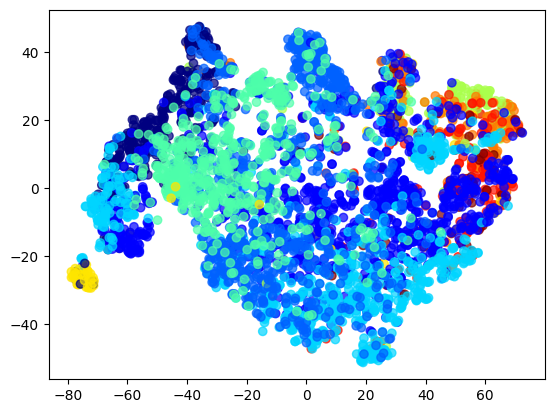

In [60]:
plt.scatter(gcn_emb_2d[:, 0], gcn_emb_2d[:, 1],
            c=labels, cmap='jet', alpha=0.7)

In [61]:
from sklearn.cluster import KMeans
import numpy as np

num_clusters = 10


kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(gcn_emb)


cluster_labels = kmeans.labels_

In [62]:
node_labels = {node: cluster_labels[idx] for idx, node in enumerate(graph.nodes)}

In [63]:
ami = adjusted_mutual_info_score(labels, cluster_labels)
print(f"Adjusted Mutual Information (AMI): {ami:.4f}")


nmi = normalized_mutual_info_score(labels, cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Mutual Information (AMI): 0.2779
Normalized Mutual Information (NMI): 0.2814


## Обид со спектрално кластерирање

In [64]:
from sklearn.cluster import SpectralClustering

In [67]:
clustering = SpectralClustering(n_clusters=10)

In [68]:
clustering.fit(gcn_emb)

SpectralClustering(n_clusters=10)

In [69]:
spectral_labels = clustering.labels_

In [70]:
tsne = TSNE(n_components=2)

In [71]:
tsne_emb = tsne.fit_transform(gcn_emb)

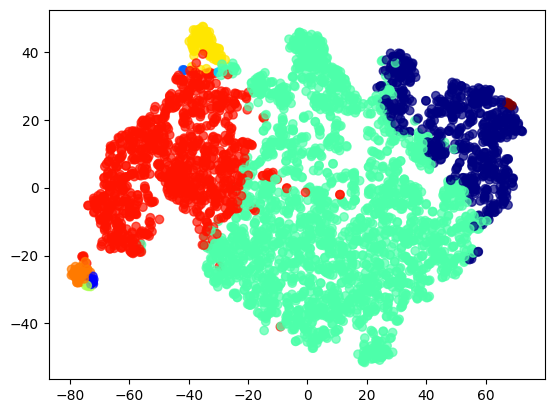

In [72]:
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1],
            c=spectral_labels, cmap='jet', alpha=0.7)

In [73]:
ami = adjusted_mutual_info_score(labels, spectral_labels)
print(f"Adjusted Mutual Information (AMI): {ami:.4f}")


nmi = normalized_mutual_info_score(labels, spectral_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

Adjusted Mutual Information (AMI): 0.2589
Normalized Mutual Information (NMI): 0.2634
